# Activity 4.1. EM for GMM
In this activity we practice Hard and Soft Expectation Maximimization to train Gaussian Mixture Models.

## Libraries
In this activity we need to use some special packages to generate synthetic data and sample from gaussian mixture models. In particular, we use `mvtnorm` for generating  multivariate Gaussian sampels and `clusterGeneration` for generating covariance matrices. 

In [65]:
#install.packages("mvtnorm")
#install.packages("clusterGeneration")

In [66]:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2) # plotting
library(reshape2) # data wrangling!
library(clusterGeneration) # generates the covariance matrices that we need for producing synthetic data.
library(repr)

In [67]:
options(repr.plot.width=6, repr.plot.height=6, warn=-1)

## Synthetic Data Generation
In this part we mix samples from a few Gaussian distribution to produce Gaussian mixtures. In the next steps we try to train a mixture model based on these samples.

Let's start with setting the main parameters...

In [68]:
# Set the parameters:
seed = 14102018
set.seed(seed) # save the random seed to make the results reproducble

In [69]:
N <- 1000 # number of samples
K <- 3    # number of clusters
D <- 2    # number of dimensions

... and then initiating the matrices

In [70]:
# Initializations:

# randomly generate K numbers
Phi <- runif(K)

# divide by their sum and the resulting as each class prior probabilities
Phi <- Phi/sum(Phi) 

# initialise a matrix for storing the effective number of points assigned to each cluster
Nk <- matrix(0,nrow = K)

# randomly generate centriods (means) of the clusters 
Mu <- matrix(runif(K*D, min=-1)*10, nrow = K, ncol = D)

# initialise a matrix for storing the covariance matrix
Sigma <- matrix(0,nrow = K, ncol = D^2)

Now, we can easily create covariance matrices

In [71]:
# Create the covariance matrices:
for (k in 1:K){
    # For each cluster generate one sigma matrix
    Sigma[k,] <- genPositiveDefMat(D)$Sigma[1:D^2]
}

In [72]:
genPositiveDefMat(D)

5.375958,-2.041306
-2.041306,3.042371


`genPositiveDefMat(dim, covMethod, alphad, eta, rangeVar, lambdaLow, ratioLambda)`

Generate a positive definite matrix/covariance matrix.  
* `dim`:Dimension of the matrix to be generated.
* `covMethod`: Method to generate positive definite matrices/covariance matrices ("eigen", "onion", "c-vine", "unifcorrmat")
* `alphad`: parameter for unifcorrmat method to generate random correlation matrix. `alphad=1` for uniform. alphad should be positive.
* `eta`: parameter for “c-vine” and “onion” methods to generate random correlation matrix eta=1 for uniform. eta should be positive.
* `rangeVar`: Range for variances of a covariance matrix (see details). The default range is `[1,10]` which can generate reasonable variability of variances.
* `lambdaLow`: Lower bound on the eigenvalues of cluster covariance matrices. 
    * If the argument covMethod="eigen", eigenvalues are generated for cluster covariance matrices. The eigenvalues are randomly generated from the interval `[lambdaLow, lambdaLow∗ratioLambda]`. In our experience, lambdaLow=1 and ratioLambda=10 can give reasonable variability of the diameters of clusters. lambdaLow should be positive.
* `ratioLambda`: The ratio of the upper bound of the eigenvalues to the lower bound of the eigenvalues of cluster covariance matrices. See lambdaLow.

OK! Now we ready to generate our synthetic data. Note that we should **remove the labales** as the EM algorithm should be able to cluster the points **without knowing the real cluster labels**.

In [73]:
# Generate data:
# initialise an empty dataset
data <- data.frame(K=integer(), X1=double(), X2=double())

# geenrate labels (they will not be used in EM, just for validation)
data[1:N,'K'] <- sample(1:K, N, replace = TRUE, prob = Phi)

## For each cluster k:
for (k in 1:K){
    # count the effective number of points assigned to current cluster k:
    Nk[k] <- sum(data$K==k) 
    # generate synthetic data points according to how many(Nk[k]), mean(Mu[k,]), covariance matrix(sigma):
    data[data$K==k, 2:3] <- rmvnorm(n = Nk[k], Mu[k,], matrix(Sigma[k,], ncol=D))
}

# Remove the lables! So, our GMM has no clue what are the real labels.
X <- as.matrix(data[,-1]) 

To finish this part, let's take a quick look at the generated data.

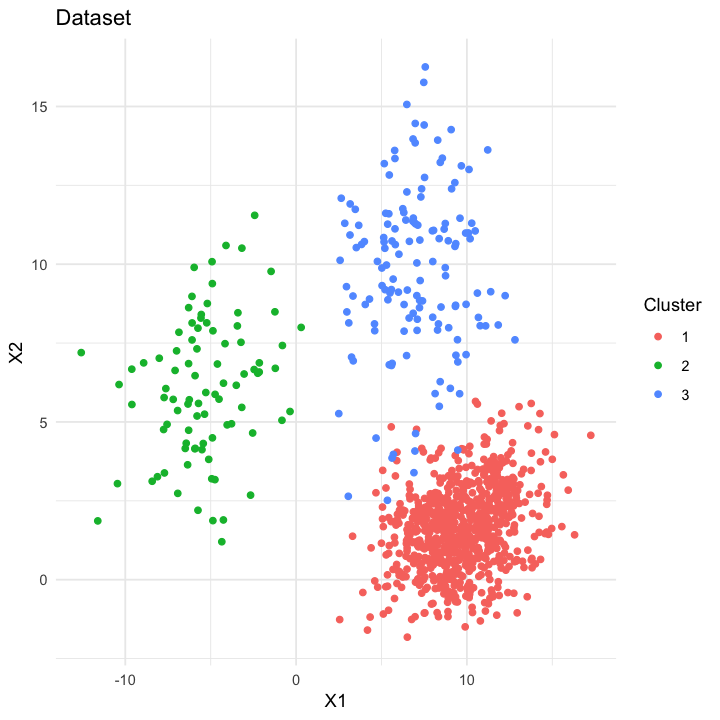

In [74]:
# Visualize the data (with the real labels)
ggplot(data=data, aes(x=X1, y=X2, color=factor(K))) + geom_point() +
    scale_color_discrete(guide = guide_legend(title = "Cluster")) + 
    ggtitle ('Dataset') + theme_minimal()

---

## Soft EM for GMM
We generated our data previously, so we know the real cluster labels. However, we pretend we do not have the real lables. Let's implement **Soft Expectation Maximization** for our GMM. Again we use `.hat` name convention to differentiate the real and estimated values. 

Let's set the parameters and then perform the initializations.

In [75]:
# Setting the parameters:
eta.max <- 100      # maximum number of iteratins
epsilon <- 0.01     # termination threshold 

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

# Ramdom cluster initialization:
set.seed(seed)# save the random seed to make the results reproducible

# assume all clusters have the same size (we will update this later on)
Phi.hat <- 1/K # equal prior

# initialise equal effective number of data points assigned to each clusters
Nk.hat <- matrix(N/K,nrow = K)

# randomly sample from ensemble to choose K data points as cluster means
Mu.hat <- as.matrix(X[sample(1:N, K), ])

# initialise an empty covariance matrices (we will fill them)
Sigma.hat <- matrix(,nrow = K, ncol = D^2) 

# initialise an empty posterior matrix (the membership estimates will be stored here)
post <- matrix(,nrow=N, ncol=K)

# for each cluster k:
for (k in 1:K){
    # initiate the k covariance matrix as an identity matrix (we will update it later on)
    Sigma.hat[k,] <- diag(D)
}

In [76]:
diag(D)

1,0
0,1


The following is the main loop of EM algorithm. In this loop, we iteratively take E and M steps until the termination criterion is met.

`dmvnorm(x, mean = rep(0, p), sigma = diag(p), log = FALSE)`  
It provides the density function for the multivariate normal distribution with mean equal to mean and covariance matrix sigma.
* `x`: vector or matrix of quantiles. If x is a matrix, each row is taken to be a quantile.
* `mean`: mean vector, default is `rep(0, length = ncol(x))`.
* `sigma`: covariance matrix, default is `diag(ncol(x))`.
* `log`: logical; if TRUE, densities d are given as log(d).

**E Step**:


$$p(z_k)p(\pmb{x}|z_k) = \pi_k\cdot N(\pmb{x}|\mu_i,\Sigma_k)$$

$$p(\pmb{x}) = \sum_{z}{p(\pmb{z})p(\pmb{x}|\pmb{z})} = \sum_{j=1}^{K}{ \pi_{ j }\cdot N(\pmb{x}|\mu_j,\Sigma_j)}$$

Each cluster responsibilities: 
$$\gamma (z_{ k })=\cfrac { \pi_{ k }\cdot N(\pmb{x}|\mu_k,\Sigma_k)}{\sum_{j=1}^{K}{ \pi_{ j }\cdot N(\pmb{x}|\mu_j,\Sigma_j)}} $$

**M Step**:
1. Get the effective number of points assigned to cluster $k$ : $N_k$
$$N_k = \sum_{n=1}^{N}{\gamma(z_{nk})}$$

2. Update the mean: $\pmb{\mu}_k$

$$\pmb{\mu}_k=\frac{1}{N_k}\sum_{n=1}^{N}{\gamma(z_{n_k})\pmb{x}_n}$$

3. Update the covariance matrix: $\pmb{\Sigma}_k$
$$\pmb{\Sigma}_k = \frac{1}{N_k}\sum_{n=1}^{N}{\gamma(z_{nk})\cdot(\pmb{x}_{n}-\pmb{\mu}_{k})\times(\pmb{x}_n-\pmb{\mu}_k)^T}$$

> Note: this formula is from PRML, each data point is a column vector, then $\pmb{x}_{n}$ is a $D\times 1$ matrix, so does the $\pmb{\mu}_k$. Then, $\pmb{x}_{n}-\pmb{\mu}_{k}:= M(D\times 1)$. Hence:
$$(\pmb{x}_{n}-\pmb{\mu}_{k})\times(\pmb{x}_n-\pmb{\mu}_k)^T = M(D\times 1) \times M(D\times 1)^T = M(D\times D)$$

In this tutorial materials, we use row vector instead of column vector to represent a data point. Thus, to simplify the calculation, we use the $\pmb{x}$ ( $N \times D$ ) and $\pmb{\mu}$ ( $N \times D$ ) to perform the matrices multiplication:

$$\pmb{\Sigma}_k = \frac{1}{N_k} \cdot \gamma(z_{nk})\cdot(\pmb{x}-\pmb{\mu})^T \times (\pmb{x}-\pmb{\mu})$$

> Note: Matrix $\pmb{x}$ is a $N\times D$ matrix, $\pmb{\mu}$ is also a $N\times D$ matrix. Then, $\pmb{x}-\pmb{\mu}$ is a $N\times D$ matrix. The order of multiplication between matrices is important. Since:
$$M(N\times D) \times M(N\times D)^T = M(N\times N) $$
$$M(N\times D)^T \times M(N\times D) = M(D\times D) $$
Different order yields different results.

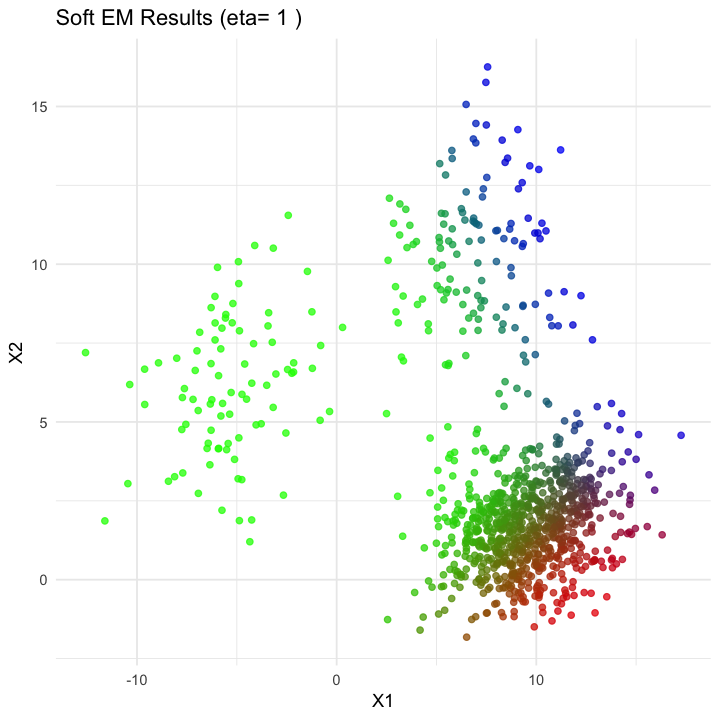

maximum number of itterations: 19 


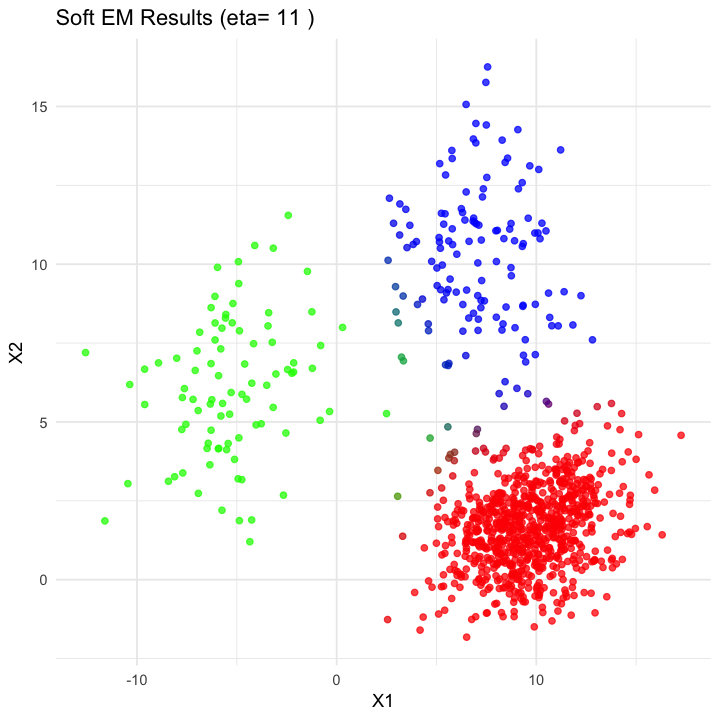

In [77]:
# Build the GMM model
Mu.hat.old <- Mu.hat # store the old estimated means

while (!terminate){
    # E step:    
    for (k in 1:K){
        # calculate the posterior based on the estimated means,covariance and cluster size:
        # Bayes' theorem: posterior = likelihood * prior
        # 计算后验概率
        post[,k] <- dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k] 
    }
    # normalization (to make sure post(k) is in [0,1] and sum(post)=1)
    # 归一化
    post <- post/rowSums(post) 

    # M step:
    for (k in 1:K){
        # recalculate the estimations:
        
        # step1. get N_k: # the effective number of point in cluster k
        Nk.hat[k] <- sum(post[,k])
        
        # step2. update the mean (Mu)
        Mu.hat[k,] <- colSums(post[,k] *X)/Nk.hat[k] # new means (cluster cenroids)
        
        # step3. update the covariance matrix (Sigma)
        Mu.matrix <- matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE) # used for shorthand
        Sigma.hat[k,] <- (t(X - Mu.matrix) %*% (post[,k] * (X - Mu.matrix))) / Nk.hat[k]
        
        # step4. update prior
        Phi.hat[k] <- Nk.hat[k] / N
    }

    if (eta %% 10 == 1) {
        print(ggplot(data=as.data.frame(X), aes(x=X1, y=X2)) + 
        geom_point(color=rgb(post), alpha=0.75) +
        ggtitle (paste('Soft EM Results (eta=', eta, ')')) + theme_minimal())
        }
    
    # increase the epoch counter
    eta <- eta + 1
    
    # check the termination criteria
    cond1 <- (eta > eta.max) # check the boundaries
    cond2 <- (sum(abs(Mu.hat.old - Mu.hat)) <= epsilon) # check the difference between updates within a threshold
    terminate <- cond1 | cond2
    
    # update the record of the means (neccessary for checking the termination criteria)
    Mu.hat.old <- Mu.hat

}
# That's it! Let see how many iterations we had:
cat('maximum number of itterations:',eta,'\n')

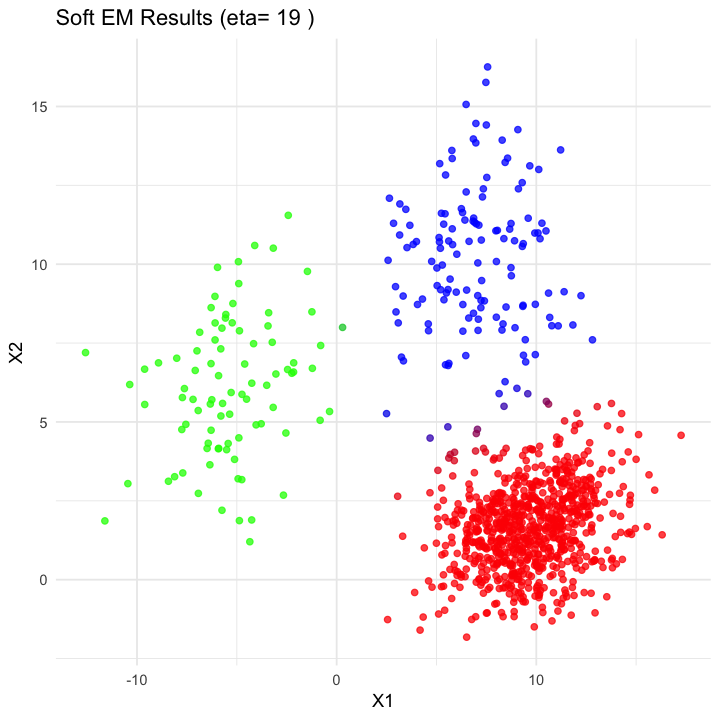

In [78]:
print(ggplot(data=as.data.frame(X), aes(x=X1, y=X2)) + 
        geom_point(color=rgb(post), alpha=0.75) +
        ggtitle (paste('Soft EM Results (eta=', eta, ')')) + theme_minimal())

**Note:** The color code of the above figure(s) can be very different than the plot we draw using the real labels. This happens because the order of the estimated culsters may not be the same as the real order of the clusters.

As we observe in the plot(s), **the intensity of the color** of a particular point indicates **the probability of that point being from the cluster which that color associated with**. As a result, we see points with mixing colors (this is specific to soft assignment).

## Discussions
We built a GMM using soft EM and visualized it. Other than visualization, one can compare the real (generative) and estimated parameters to validate the discovered clusters. Perform this comparison for mean, covariance and effective number of points in each clusters, then discuss your findings. 

> Note that the order of clusters, and hence their means, covariances, etc., may vary as EM has no idea about the real order of the clusters in the generation process. To make it easier to compare these values, you can sort them before comparing them.

## Hard EM for GMM
In the above experiments, we implemented Soft EM. Now, we modify the code and develop a **Hard EM** for our GMM. Recal that in hard EM, $\gamma(z_{nk})$ only takes binary values as a data point either is a member of a cluster or not. To spot the difference between hard and soft EM, refer to the lines that are marked by `# hard assignments`.

In [101]:
# Setting the parameters:
eta.max <- 100      # maximum number of iteratins
epsilon <- 0.01     # termination threshold 

# Initialzations:
eta <- 1            # epoch counter
terminate <- FALSE  # termination condition

# Ramdom cluster initialization:
set.seed(seed) # save the random seed to make the results reproducble

# assume all clusters have the same size (we will update this later on)
Phi.hat <- 1/K # equal prior

# initialise equal effective number of data points assigned to each clusters
Nk.hat <- matrix(N/K,nrow = K)

# randomly sample from ensemble to choose K data points as cluster means
Mu.hat <- as.matrix(X[sample(1:N, K), ])

# initialise an empty covariance matrices (we will fill them)
Sigma.hat <- matrix(,nrow = K, ncol = D^2) 

# initialise an empty posterior matrix (the membership estimates will be stored here)
post <- matrix(,nrow=N, ncol=K)

# for each cluster k:
for (k in 1:K){
    # initiate the k covariance matrix as an identity matrix (we will update it later on)
    Sigma.hat[k,] <- diag(D)
}

In [103]:
? par

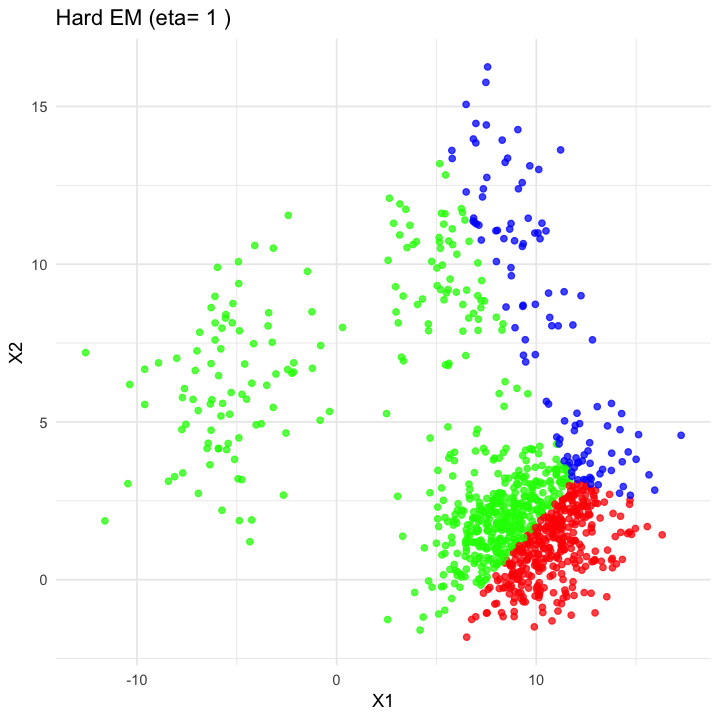

maximum number of itterations: 13 


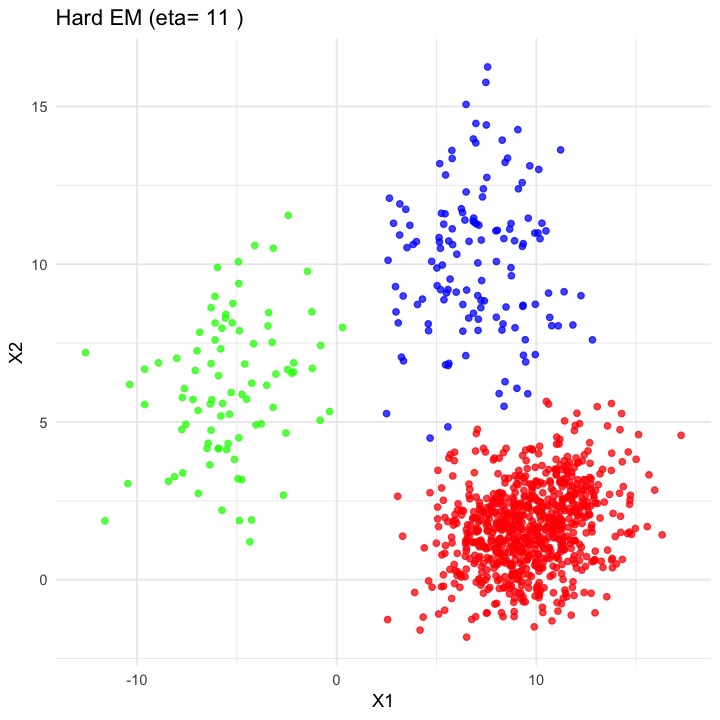

In [102]:
# Build the GMM model
Mu.hat.old <- Mu.hat # store the old estimated means

# Main Loop
while (!terminate){

    # E step:   
    for (k in 1:K){
        ## calculate the posterior based on the estimated means,covariance and cluster size:
        post[,k] <- dmvnorm(X, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
    }
    
    # Hard assignments:
    # apply(post, 1, max): 对post的每一行（1）找出最大值，然后输出
    # for each point find the cluster with the maximum (estimated) probability
    max.prob <- post == apply(post, 1, max) #得到一个只含true/false的矩阵
    
    # assign each point to the cluster with the highest probability
    post[max.prob] <- 1 
     # remove points from clusters with lower probabilites
    post[!max.prob] <- 0


     # M step:
    for (k in 1:K){
        # recalculate the estimations:
        
        # step1. get N_k: # the effective number of point in cluster k
        Nk.hat[k] <- sum(post[,k])
        
        # step2. update the mean (Mu)
        Mu.hat[k,] <- colSums(post[,k] *X)/Nk.hat[k] # new means (cluster cenroids)
        
        # step3. update the covariance matrix (Sigma)
        Mu.matrix <- matrix(Mu.hat[k,],nrow = N, ncol=D, byrow = TRUE) # used for shorthand
        Sigma.hat[k,] <- (t(X - Mu.matrix) %*% (post[,k] * (X - Mu.matrix))) / Nk.hat[k]
        
        # step4. update prior
        Phi.hat[k] <- Nk.hat[k] / N
    }
    
    # visualization
    if (eta %% 10 == 1){
        print(ggplot(data=as.data.frame(X), aes(x=X1, y=X2)) + 
        geom_point(color=rgb(post), alpha=0.75) +
        ggtitle (paste('Hard EM (eta=', eta,')')) + theme_minimal())
        #line <- readline()
    }
    #par(new=FALSE)
    
    # increase the epoch counter
    eta <- eta+1
    
    # check the termination criteria
    cond1 <- (eta > eta.max) # check the boundaries
    cond2 <- (sum(abs(Mu.hat.old - Mu.hat)) <= epsilon) # check the difference between updates within a threshold
    terminate <- cond1 | cond2
    
    # record the means (neccessary for checking the termination criteria)
    Mu.hat.old <- Mu.hat
}
# That's it! Let see how many iterations we had:
cat('maximum number of itterations:',eta,'\n')

In contrast with soft assignments, here each point only assigned to one cluster. Therefore, we do not see the any point with mixed colors.

## Discussions

### Initialization Effect
In the above experiments, we used a simple but reasonably good initialization. Try some other initializations, reapet the experiments and study the results. For example, you can change

`Mu.hat <- as.matrix(X[sample(1:N, K), ]) # randomly choose K samples as cluster means`

to 

`Mu.hat <- matrix(0, nrow = K, ncol = D) # initialize all cluster means to the origin`

or

`Sigma.hat[k,] <- diag(D) # initialize with identity covariance matrix`

to 

`Sigma.hat[k,] <- genPositiveDefMat(D)$Sigma[1:D^2] # initialize with random covariance matrix`

## Kmeans vs. GMM
Discuss the followings:

* What are the main differences between Kmeans clustering and (hard) GMM? Explain **the assumptions** behind each one of them, as well as their **limitaitons** and **strength** (**Hint:** Think about the covariance matrix!).

Answer:

* How one can combine Kmeans and GMM to have the bests of both worlds (**Hint:** Think about GMM initialization)?

> **Answer**:  
In practice, the K-mean algorithm is often used to initialize the parameters, such as the centroids $\mu_k$, in a Gaussian mixture model before applying the EM algorithm